# Introduction to Bayesian Inference part2
1st Jun  Hiroshi Urata  
Table of Contents  
    1. Probability distribution
        - Gamma distribution
            - Expectation
            - Conjugacy
        - Student t distribution
    2. Bayesian inference with gaussian distribution
        - Observation
        - Model
        - prior distribution
        - posterior distribution
        - predictive distribution


In [10]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import gamma
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
%matplotlib inline
plt.style.use('dark_background')

## 1. Probability distribution  

- Gamma distribution  
$$Gam(\lambda | a, b) = \frac{b^a}{\Gamma(a)}\lambda^{a-1}e^{-b\lambda}$$  

    Expectation (Demo) 
        mean : a/b
    Conjugacy (Demo)

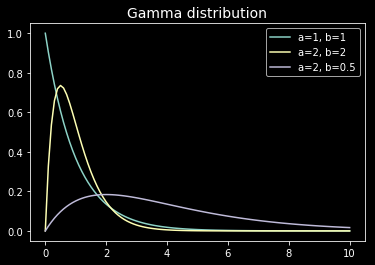

In [11]:
# parameter of gamma distribution
a_list = [1,2,2]
b_list = [1,2,0.5]

X = np.linspace(0,10,101)

# plot t distribution
for a, b in zip(a_list, b_list):
    y = gamma.pdf(x=X, a=a, scale=1/b)
    plt.plot(X,y,label='a={}, b={}'.format(a,b))

plt.title('Gamma distribution', fontsize=14)
plt.legend()

plt.show()

- Strudent T distribbution  
  
$$St(x|\nu, \mu, \lambda) = \frac{\Gamma(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2})} \left(\frac{\lambda}{\pi\nu}\right)^{\frac{1}{2}}\left( 1 + \frac{\lambda(x-\mu)^2}{\nu}\right)^{\frac{\nu+1}{2}}$$　　
　　
When $\nu$ approaches infinity, t-distribution $St(x|\mu, \lambda, \nu)$ becomes gaussian distribution $N(x|\mu, \lambda)$.  
(Demo)


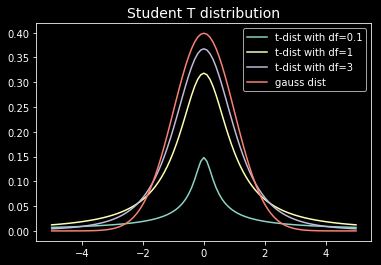

In [12]:
# parameter for student t distribution
df_list = [0.1,1,3]
mu = 0
var = 1

X = np.linspace(-5,5,101)

# plot t distribution
for df in df_list:
    y = t.pdf(x=X, df=df, loc=mu, scale=np.sqrt(var))
    plt.plot(X,y,label='t-dist with df={}'.format(df))
    
# plot gauss distribution
y = norm.pdf(x=X, loc=mu, scale=np.sqrt(var))
plt.plot(X,y,label='gauss dist')

plt.title('Student T distribution', fontsize=14)
plt.legend()

plt.show()

## 2. Bayesian inference with gaussian distribution  
50 number of Ph column in 'Wine Quality Data Set' is utilized here.  


It looks like the following.

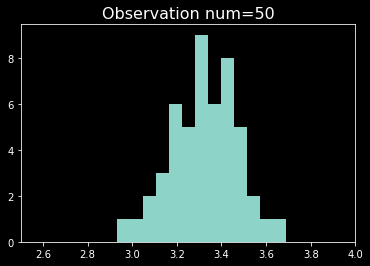

In [13]:
# observation pH of red wine data
N=50 
obs_data = pd.read_csv('winequality-red.csv',sep=';').sample(N,random_state=16).pH.values

plt.hist(obs_data,bins=13)
plt.xlim(2.5,4)
plt.title('Observation num={}'.format(N),fontsize=16)
plt.show()

- Model  
Assume the observation follows univariate gaussian distribution.
  
$$p(x) = N(x|\mu, \lambda^{-1}) = \frac{1}{\sqrt{2 \pi \lambda^{-1}}}\exp\left\{\frac{1}{2}\lambda(x-\mu)^2\right\}$$

- Prior distribution  
    Because conjugate prior for precision and mean of univariate gaussian distribution is gauss-gamma distribution. Gauss-gamma distribution is gonna be applied as prior distribution here.  
    
$$\begin{eqnarray}NG(\mu, \lambda | m, \beta,  a,b) &=& N(\mu | m, (\beta\lambda)^{-1}) Gam(\lambda|a,b)\end{eqnarray}$$

In [8]:
def gauss_gamma_pdf(X, m, beta, a, b):
    """
    X : consists of mean and lambda
    """
    X = X.reshape(2,-1)
    gamma_prob = gamma.pdf(
        X[1], 
        a=a, 
        scale=1/b
    )
    norm_prob = norm.pdf(
        X[0], 
        loc=m, 
        scale=np.sqrt(1/(beta * X[1]))
    )
    
    return gamma_prob * norm_prob

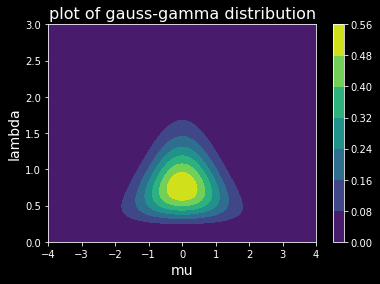

In [14]:
# parameter of gauss-gamma distribution
m = 0
beta=2
a=5
b=6

x = np.linspace(-4,4,101)
y = np.linspace(0,3,101) + 1e-10
xx, yy = np.meshgrid(x,y)

prob = gauss_gamma_pdf(
    np.vstack([xx.ravel(), yy.ravel()]), 
    m=m, beta=beta, a=a, b=b
)

# plot gauss gamma distribution
contourf = plt.contourf(xx,yy,prob.reshape(xx.shape))
plt.colorbar(contourf)
plt.xlabel('mu',fontsize=14)
plt.ylabel('lambda',fontsize=14)
plt.title('plot of gauss-gamma distribution',fontsize=16)
plt.show()

It looks like 'ONIGIRI' in convenience store in Japan...:)

Therefore posterior distribution looks like following.  
  
$$\begin{eqnarray}p(\mu, \lambda | X) &\propto& p(X| \mu, \lambda^{-1}) p(\lambda, \mu)  \\
&=& \prod^{N}_{n=1}N(x_n|\mu, \lambda^{-1})NG(\mu, \lambda | m, \beta, a,b)\end{eqnarray}$$

With calculation, we will get the following result,   
    
$$\begin{eqnarray}p(\mu, \lambda|X) &=& NG(\mu, \lambda | \hat{m}, \hat{\beta}, \hat{a},\hat{b}) \\
&=& N(\mu|\hat{m}, (\hat{\beta}\lambda)^{-1})Gam(\lambda|\hat{a},\hat{b})\end{eqnarray}$$
  
    
$$\hat{\beta} = N + \beta$$
$$\hat{m} = \frac{1}{\hat{\beta}}\left( \sum_{n=1}^{N} x_n + \beta m\right)$$
$$\hat{a} = \frac{N}{2} + a$$
$$\hat{b} = \frac{1}{2}\left(\sum^{N}_{n=1}x_n^2　+ \beta m^2 - \hat{\beta}\hat{m}^2 \right) + b$$

In [16]:
def post_dist(X, mu_0, beta, a, b):
    """
    X : observation
    followings are parameters of prior normal-gamma
    mu_0, beta, a, b
    """
    a_hat = (1/2) * X.shape[0] + a
    beta_hat = beta + X.shape[0]
    mu_hat = (X.sum() + beta * mu_0) / beta_hat
    b_hat = (1/2) * (-beta_hat * (mu_hat **2) + \
                     (X**2).sum() + beta_hat*(mu_0**2)) + b
    
    return mu_hat, beta_hat, a_hat, b_hat

Parameter of posterior distribution : 
Mean :  3.1940384615384616
Beta :  52
a :  30.0
b :  17.16032596153849


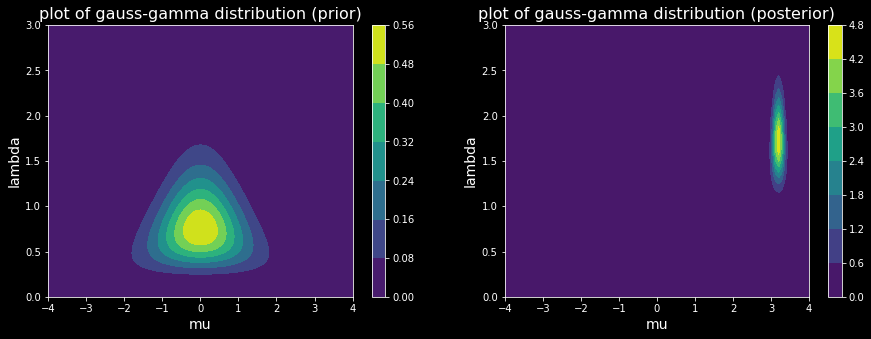

In [17]:
# parameter of prior distribution
m = 0
beta=2
a=5
b=6

# compute parameter of posterior distribution
mu_hat, beta_hat, a_hat, b_hat = post_dist(
    obs_data, mu_0=m, beta=beta, a=a, b=b)
print('Parameter of posterior distribution : ')
print('Mean : ', mu_hat)
print('Beta : ', beta_hat)
print('a : ', a_hat)
print('b : ', b_hat)

x = np.linspace(-4,4,101)
y = np.linspace(0,3,101) + 1e-10
xx, yy = np.meshgrid(x,y)

plt.figure(figsize=(15,5))
for i, (mu, beta, a, b) in enumerate(zip(
            [m,mu_hat], [beta, beta_hat], [a, a_hat],[b, b_hat])):
    prob_post = gauss_gamma_pdf(
        np.vstack([xx.ravel(), yy.ravel()]), 
        m=mu, beta=beta, a=a, b=b
    )

    # plot gauss gamma distribution
    plt.subplot(1,2,i+1)
    contourf = plt.contourf(xx,yy,prob_post.reshape(xx.shape))
    plt.colorbar(contourf)
    plt.xlabel('mu',fontsize=14)
    plt.ylabel('lambda',fontsize=14)
    title = 'prior' if i ==0 else 'posterior'
    plt.title('plot of gauss-gamma distribution ({})'.format(title),
              fontsize=16)
    
plt.show()

## 5. Predictive distribution  
For predictive distribution, parameters $\mu$ and $\lambda$ is supporsed to be integrated out by calculating following.  
  
$$ p(x_* ) = \int \int p(x_*| \mu, \lambda) d\mu d\lambda$$  
Or from bayesian theorem, following can be  also calculated.  
  
$$lnp(x_*) = lnp(x_* | \mu, \lambda) - lnp(\mu, \lambda | x_*)  + const$$ 

As a result, we got student-T distribution.
$$ p(x_*) = st(x_*|\mu_s, \lambda_s, \nu)$$
$$\begin{eqnarray}\mu_s &=& m\\
\lambda_s &=& \frac{\beta a }{(1+\beta)b}\\
\nu_s &=& 2a
\end{eqnarray}$$

In [18]:
from scipy.stats import t
class predictive_t():
    def __init__(self, m, beta, a, b):

        self.mu = m
        self.lam = (beta * a) / ((1+beta)*b)
        self.nu = 2 * a
        
    def pdf(self, X):
        return t.pdf(X,df=self.nu, loc =mu, scale = 1/np.sqrt(self.lam))

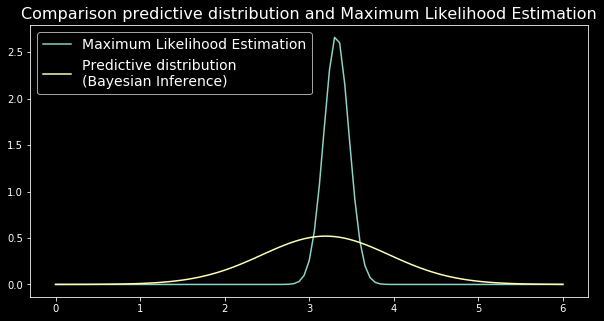

In [19]:
# data to plot predictive distribution of t
pred_t = predictive_t(m=mu_hat,beta=beta_hat,a=a_hat,b=b_hat)
X = np.linspace(0,6,101)
y_pred = pred_t.pdf(X)

# data to plot observations
y_mle = norm.pdf(X, 
                  loc=obs_data.sum() / obs_data.shape[0], 
                  scale= np.sqrt(obs_data.var())
                 )

plt.figure(figsize=(10,5))
plt.plot(X,y_mle,label='Maximum Likelihood Estimation')
plt.plot(X,y_pred,label='Predictive distribution\n(Bayesian Inference)')
plt.legend(fontsize=14)
plt.title('Comparison predictive distribution and Maximum Likelihood Estimation',
         fontsize=16)

plt.show()